<a href="https://colab.research.google.com/github/christophergaughan/progenitor-glycosylation-scanner/blob/main/fda_therapeutics_validation_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FDA Therapeutics Glycosylation Validation (v3)
## AntibodyML Consulting LLC - Enhanced Progenitor Glycosylation Scanner

### v3 Methodology Enhancements:
1. **AntPack IMGT Numbering** - Colab-friendly, precise position mapping
2. **X-Position Efficiency Scoring** - Shakin-Eshleman rules for glycosylation efficiency
3. **NXT vs NXS Differentiation** - NXT motifs ~2.5x more likely occupied
4. **Vernier Zone Flagging** - IMGT positions 75-88 structural risk
5. **Occupancy Score** - Probabilistic glycosylation likelihood
6. **RiskLevel Stratification** - CRITICAL/HIGH/MEDIUM/LOW classification

---

### Scientific Foundation

**van de Bovenkamp et al. (2018, 2023)** demonstrated that 79-86% of Fab N-glycosylation sites originate from progenitor positions—sequences one mutation away from creating N-X-S/T motifs.

**Shakin-Eshleman et al. (1996)** established that the amino acid at position X in N-X-S/T dramatically affects glycosylation efficiency, with some residues (Pro) completely blocking and others (Ser, Thr, Ala) maximizing occupancy.

This scanner integrates both insights with structural context to predict actual glycosylation risk.

---

**Repository:** [progenitor-glycosylation-scanner](https://github.com/AntibodyML/progenitor-glycosylation-scanner)  
**Contact:** AntibodyML Consulting LLC

# Introduction: Bridging ML Antibody Design and Glycosylation Risk

### The Problem

Tools like **RFdiffusion** and other ML-based antibody design platforms are revolutionizing *de novo* antibody generation. They can produce novel sequences with remarkable speed and structural accuracy. However, these tools optimize for structure and predicted binding—they are blind to **post-translational modification liabilities**, including N-linked glycosylation in the Fab region. (Note: while such tools can *intentionally* introduce glycosylation sites as design constraints, they do not flag N-X-S/T motifs that emerge incidentally from sequence optimization.)

This matters because Fab glycosylation can:
- Alter antigen binding affinity and specificity
- Introduce batch-to-batch heterogeneity in manufacturing
- Trigger immunogenic responses (as documented with Cetuximab's α-Gal epitope)
- Complicate analytical characterization and regulatory approval

By the time these issues surface in development, significant resources have already been invested.

### Why FDA Therapeutics?

To validate our scanner, we need sequences where Fab glycosylation status is *already known* from published literature, clinical data, and mass spectrometry studies. FDA-approved therapeutics are the most thoroughly characterized antibodies on the planet.

This isn't a predictive validation—it's a **sanity check**: *Does the scanner agree with known biology?*

We also note that the scanner detects progenitor sites (sequences one mutation away from N-X-S/T) in these FDA-approved mAbs. It's important to be explicit: **not all progenitor sites will actually become glycosylated**. Progenitor detection flags *potential* risk, not certainty.

### The Insight: Progenitor Sites

The work of van de Bovenkamp *et al*.(2018, 2023) provided a crucial insight: **79-86% of Fab N-glycosylation sites in natural antibody repertoires originate from "progenitor" positions**—sequences where a single somatic hypermutation event converts a latent motif into an actual N-X-S/T sequon.

This means scanning only for existing N-X-S/T motifs misses the majority of glycosylation risk. A D-X-S/T site is one D→N mutation away from becoming glycosylated. An N-X-A site is one A→S/T mutation away. In the context of therapeutic development—or ML-generated sequences that haven't been through evolutionary selection—these progenitor sites represent latent liabilities.

### Our Approach

We built the **Enhanced Progenitor Glycosylation Scanner** to operationalize this insight:

1. **Scan for actual N-X-S/T sites** — immediate, high-weight risk
2. **Scan for progenitor sites** — D-X-S/T (D→N) and N-X-[A/V/I/L] (→S/T) — weighted by mutation probability
3. **Apply Shakin-Eshleman efficiency scoring** — not all sequons are equal; the X-position amino acid dramatically affects occupancy
4. **Differentiate NXT vs NXS** — threonine-containing motifs are ~2.5× more efficiently glycosylated
5. **Flag structural context** — CDR sites affect binding; Vernier zone sites (IMGT 75-88) affect VH/VL packing and can destabilize the Fab even when glycosylation doesn't directly contact antigen

The result is a **risk score (0-100)** that prioritizes sequences for review before they enter the development pipeline.

### This Validation

The notebook below validates the scanner against **18 FDA-approved therapeutic antibodies**. This is a deliberately conservative test:

- These antibodies have survived humanization, developability screening, lead optimization, and manufacturing scale-up
- Glycosylation liabilities have largely been engineered out
- Only **Cetuximab** retains documented Fab glycosylation (the N88 site in VH FR3 that your work highlighted)

We expect—and observe—high specificity (few false positives) because these are **curated survivors**. The scanner's real value is not in re-screening approved drugs, but in **catching liabilities in unscreened sequences**: RFdiffusion outputs, early-stage candidates, and natural repertoire antibodies before affinity maturation introduces new sites.

## Installation and Setup

In [2]:
# ============================================================================
# INSTALLATION - v3 Dependencies
# ============================================================================

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔧 Setting up Google Colab environment...")
    print()

    # Core packages
    print("📦 Installing core packages...")
    !pip install pandas numpy matplotlib seaborn scikit-learn --quiet
    print("   ✓ Core packages installed")

    # AntPack - Colab-friendly antibody numbering (GPL v0.3.8.6)
    print("\n📦 Installing AntPack for IMGT numbering...")
    !pip install antpack==0.3.8.6 --quiet
    print("   ✓ AntPack installed (GPL version)")

    print("\n✅ Setup complete!")
else:
    print("📍 Running outside Colab")
    print("   Ensure: pandas, numpy, matplotlib, seaborn, scikit-learn, antpack==0.3.8.6")

🔧 Setting up Google Colab environment...

📦 Installing core packages...
   ✓ Core packages installed

📦 Installing AntPack for IMGT numbering...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 27.6 MB/s eta 0:00:00
   ✓ AntPack installed (GPL version)

✅ Setup complete!


In [3]:
# ============================================================================
# IMPORTS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# AntPack for IMGT numbering
ANTPACK_AVAILABLE = False
try:
    from antpack import SingleChainAnnotator
    ANTPACK_AVAILABLE = True
    print("✓ AntPack available - using precise IMGT numbering")
except ImportError:
    print("⚠️ AntPack not available - will use approximate CDR boundaries")

print("✓ All packages loaded successfully")

✓ AntPack available - using precise IMGT numbering
✓ All packages loaded successfully


## X-Position Efficiency Database

Based on **Shakin-Eshleman et al. (1996)** and subsequent studies on sequon efficiency.

In [4]:
# ============================================================================
# X-POSITION EFFICIENCY SCORING (Shakin-Eshleman Rules)
# ============================================================================
# The amino acid at position X in N-X-S/T affects glycosylation efficiency
# Values represent relative glycosylation efficiency (0-1 scale)
# Reference: Shakin-Eshleman et al. (1996) J Biol Chem

X_POSITION_EFFICIENCY = {
    # High efficiency (>0.7)
    'A': 0.85,  # Alanine - small, non-polar
    'S': 0.90,  # Serine - small, polar (optimal)
    'T': 0.88,  # Threonine - small, polar
    'G': 0.80,  # Glycine - minimal side chain
    'V': 0.75,  # Valine - small hydrophobic
    'M': 0.72,  # Methionine

    # Medium efficiency (0.4-0.7)
    'I': 0.65,  # Isoleucine
    'L': 0.60,  # Leucine
    'F': 0.55,  # Phenylalanine - aromatic
    'Y': 0.50,  # Tyrosine - aromatic with OH
    'Q': 0.55,  # Glutamine
    'N': 0.50,  # Asparagine
    'H': 0.45,  # Histidine - charged aromatic
    'K': 0.45,  # Lysine - positive charge
    'R': 0.40,  # Arginine - positive charge
    'C': 0.50,  # Cysteine

    # Low efficiency (<0.4)
    'W': 0.30,  # Tryptophan - bulky aromatic
    'D': 0.25,  # Aspartate - negative charge
    'E': 0.25,  # Glutamate - negative charge

    # Blocking (0)
    'P': 0.00,  # Proline - COMPLETELY BLOCKS glycosylation
}

# NXT vs NXS efficiency multiplier
# NXT motifs are ~2.5x more efficiently glycosylated than NXS
NXT_NXS_MULTIPLIER = {
    'T': 1.0,   # NXT - reference
    'S': 0.4,   # NXS - ~40% efficiency of NXT
}

def get_sequon_efficiency(x_residue: str, third_residue: str) -> float:
    """
    Calculate glycosylation efficiency for N-X-S/T sequon.

    Args:
        x_residue: Amino acid at X position
        third_residue: S or T at +2 position

    Returns:
        Efficiency score (0-1)
    """
    x_efficiency = X_POSITION_EFFICIENCY.get(x_residue.upper(), 0.5)
    st_multiplier = NXT_NXS_MULTIPLIER.get(third_residue.upper(), 0.4)

    return x_efficiency * st_multiplier

print("✓ X-position efficiency database loaded")
print(f"  - High efficiency X residues: S ({X_POSITION_EFFICIENCY['S']}), T ({X_POSITION_EFFICIENCY['T']}), A ({X_POSITION_EFFICIENCY['A']})")
print(f"  - Blocking residue: P ({X_POSITION_EFFICIENCY['P']})")
print(f"  - NXT vs NXS: NXT is {1/NXT_NXS_MULTIPLIER['S']:.1f}x more efficient than NXS")

✓ X-position efficiency database loaded
  - High efficiency X residues: S (0.9), T (0.88), A (0.85)
  - Blocking residue: P (0.0)
  - NXT vs NXS: NXT is 2.5x more efficient than NXS


## Risk Level Classification

In [8]:
# ============================================================================
# RISK LEVEL STRATIFICATION
# ============================================================================

class RiskLevel(Enum):
    """Risk classification for glycosylation sites."""
    CRITICAL = "CRITICAL"  # CDR + high occupancy - immediate action required
    HIGH = "HIGH"          # CDR + medium occupancy OR Framework + high occupancy
    MEDIUM = "MEDIUM"      # Framework + medium occupancy OR progenitor in CDR
    LOW = "LOW"            # Low occupancy OR framework progenitor

@dataclass
class GlycosylationSite:
    """Complete characterization of a glycosylation site."""
    position: int                    # Linear sequence position (0-indexed)
    imgt_position: Optional[int]     # IMGT position (if available)
    motif: str                       # The sequon (e.g., 'NGT', 'NVS')
    site_type: str                   # 'actual' or 'progenitor_D_to_N' or 'progenitor_to_ST'
    chain: str                       # 'heavy' or 'light'
    region: str                      # 'CDR1', 'CDR2', 'CDR3', 'FR1', 'FR2', 'FR3', 'FR4', 'Vernier'
    x_residue: str                   # Amino acid at X position
    third_residue: str               # S or T at +2 position
    x_efficiency: float              # Shakin-Eshleman efficiency score
    nxt_nxs_multiplier: float        # NXT vs NXS multiplier
    occupancy_score: float           # Combined occupancy probability (0-1)
    risk_level: RiskLevel            # CRITICAL/HIGH/MEDIUM/LOW
    in_vernier_zone: bool            # IMGT 75-88
    mutation_from: Optional[str]     # For progenitors: original AA
    mutation_to: Optional[str]       # For progenitors: mutated AA
    risk_contribution: float = 0.0   # Points contributed to overall score
    blocked: bool = False            # True if sequon is blocked (e.g., Pro at X)


# IMGT Vernier zone positions (critical for VH/VL packing)
VERNIER_ZONE_IMGT = set(range(75, 89))  # IMGT 75-88

print("✓ Risk level classification loaded")
print(f"  - Levels: {[r.value for r in RiskLevel]}")
print(f"  - Vernier zone: IMGT positions 75-88")

✓ Risk level classification loaded
  - Levels: ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
  - Vernier zone: IMGT positions 75-88


## Enhanced Scanner Class (v3)

In [9]:
# ============================================================================
# ENHANCED PROGENITOR GLYCOSYLATION SCANNER v3
# ============================================================================

class EnhancedGlycosylationScannerV3:
    """
    v3 Scanner with:
    - AntPack IMGT numbering
    - X-position efficiency scoring (Shakin-Eshleman)
    - NXT vs NXS differentiation
    - Vernier zone flagging
    - Occupancy score calculation
    - RiskLevel stratification
    """

    # IMGT CDR boundaries (fallback when AntPack unavailable)
    IMGT_REGIONS = {
        'FR1': (1, 26),
        'CDR1': (27, 38),
        'FR2': (39, 55),
        'CDR2': (56, 65),
        'FR3': (66, 104),
        'CDR3': (105, 117),
        'FR4': (118, 128),
    }

    def __init__(self):
        """Initialize the v3 scanner."""
        self.annotator_heavy = None
        self.annotator_light = None

        if ANTPACK_AVAILABLE:
            try:
                self.annotator_heavy = SingleChainAnnotator(chains=['H'], scheme='imgt')
                self.annotator_light = SingleChainAnnotator(chains=['K', 'L'], scheme='imgt')
                print("✓ Scanner v3 initialized with AntPack IMGT numbering")
            except Exception as e:
                print(f"⚠️ AntPack initialization failed: {e}")
                print("   Falling back to approximate boundaries")
        else:
            print("✓ Scanner v3 initialized with approximate IMGT boundaries")

    def get_imgt_numbering(self, sequence: str, chain_type: str) -> Dict[int, int]:
        """
        Get IMGT numbering for a sequence.

        Args:
            sequence: Amino acid sequence
            chain_type: 'H' for heavy, 'L' for light

        Returns:
            Dict mapping linear position (0-indexed) to IMGT position
        """
        imgt_map = {}

        if ANTPACK_AVAILABLE:
            try:
                annotator = self.annotator_heavy if chain_type == 'H' else self.annotator_light
                numbering, percent_id, chain, err = annotator.analyze_seq(sequence)

                if err is None and numbering is not None:
                    seq_pos = 0
                    for imgt_pos, aa in numbering:
                        if aa and aa != '-':
                            # Handle insertion codes (e.g., '111A' -> 111)
                            try:
                                imgt_num = int(''.join(filter(str.isdigit, str(imgt_pos))))
                                imgt_map[seq_pos] = imgt_num
                            except:
                                imgt_map[seq_pos] = seq_pos + 1
                            seq_pos += 1
            except Exception as e:
                pass

        # Fallback: approximate mapping
        if not imgt_map:
            for i in range(len(sequence)):
                imgt_map[i] = i + 1

        return imgt_map

    def get_region(self, imgt_position: int) -> str:
        """
        Determine IMGT region for a position.

        Args:
            imgt_position: IMGT position number

        Returns:
            Region name (e.g., 'CDR1', 'FR3')
        """
        for region, (start, end) in self.IMGT_REGIONS.items():
            if start <= imgt_position <= end:
                return region
        return 'Unknown'

    def is_in_vernier_zone(self, imgt_position: int) -> bool:
        """Check if position is in Vernier zone (IMGT 75-88)."""
        return imgt_position in VERNIER_ZONE_IMGT

    def calculate_occupancy_score(self, x_residue: str, third_residue: str,
                                  region: str, is_vernier: bool,
                                  is_progenitor: bool = False) -> float:
        """
        Calculate occupancy probability score.

        Combines:
        - X-position efficiency (Shakin-Eshleman)
        - NXT vs NXS multiplier
        - Regional context
        - Progenitor probability

        Returns:
            Occupancy score (0-1)
        """
        # Base efficiency from sequon
        base_efficiency = get_sequon_efficiency(x_residue, third_residue)

        # Regional accessibility modifier
        region_modifier = 1.0
        if region.startswith('CDR'):
            region_modifier = 1.2  # CDRs are surface-exposed
        elif region == 'FR3' or is_vernier:
            region_modifier = 0.9  # FR3/Vernier partially buried
        else:
            region_modifier = 0.8  # Other frameworks

        # Progenitor discount (probability of mutation occurring)
        # D→N is ~16.5% likely via SHM, other mutations less likely
        progenitor_modifier = 0.25 if is_progenitor else 1.0

        occupancy = base_efficiency * region_modifier * progenitor_modifier

        return min(occupancy, 1.0)

    def classify_risk_level(self, occupancy_score: float, region: str,
                           is_vernier: bool, site_type: str) -> RiskLevel:
        """
        Classify site risk level.

        Args:
            occupancy_score: Calculated occupancy probability
            region: IMGT region
            is_vernier: Whether in Vernier zone
            site_type: 'actual' or 'progenitor_*'

        Returns:
            RiskLevel enum value
        """
        is_cdr = region.startswith('CDR')
        is_progenitor = site_type != 'actual'

        # CRITICAL: CDR + high occupancy actual site
        if is_cdr and not is_progenitor and occupancy_score >= 0.5:
            return RiskLevel.CRITICAL

        # HIGH: CDR actual with medium occupancy OR framework actual with high occupancy
        if is_cdr and not is_progenitor and occupancy_score >= 0.3:
            return RiskLevel.HIGH
        if not is_cdr and not is_progenitor and occupancy_score >= 0.5:
            return RiskLevel.HIGH

        # MEDIUM: Any actual site OR CDR progenitor OR Vernier
        if not is_progenitor:
            return RiskLevel.MEDIUM
        if is_cdr and is_progenitor:
            return RiskLevel.MEDIUM
        if is_vernier:
            return RiskLevel.MEDIUM

        # LOW: Framework progenitors
        return RiskLevel.LOW

    def scan_actual_sites(self, sequence: str, chain_type: str,
                         imgt_map: Dict[int, int]) -> List[GlycosylationSite]:
        """
        Find actual N-X-S/T glycosylation sites.

        Now detects ALL N-X-S/T sequons including proline-blocked sites.
        Proline at X position blocks OST access, resulting in 0 occupancy,
        but site is still reported for transparency (Shakin-Eshleman 1996).

        Args:
            sequence: Amino acid sequence
            chain_type: 'H' or 'L'
            imgt_map: Position to IMGT mapping

        Returns:
            List of GlycosylationSite objects
        """
        sites = []
        chain_name = 'heavy' if chain_type == 'H' else 'light'

        for i in range(len(sequence) - 2):
            # Detect ALL N-X-S/T sequons - let efficiency scoring handle blocked sites
            if sequence[i] == 'N' and sequence[i+2] in ['S', 'T']:
                imgt_pos = imgt_map.get(i, i + 1)
                region = self.get_region(imgt_pos)
                is_vernier = self.is_in_vernier_zone(imgt_pos)

                x_residue = sequence[i+1]
                third_residue = sequence[i+2]
                x_eff = X_POSITION_EFFICIENCY.get(x_residue, 0.5)
                nxt_mult = NXT_NXS_MULTIPLIER.get(third_residue, 0.4)

                # Check if site is blocked (Proline at X = complete block)
                is_blocked = (x_residue == 'P')

                occupancy = self.calculate_occupancy_score(
                    x_residue, third_residue, region, is_vernier, is_progenitor=False
                )

                # Blocked sites get special risk classification
                if is_blocked:
                    risk = RiskLevel.LOW  # Blocked = no glycosylation risk
                else:
                    risk = self.classify_risk_level(occupancy, region, is_vernier, 'actual')

                sites.append(GlycosylationSite(
                    position=i,
                    imgt_position=imgt_pos,
                    motif=sequence[i:i+3],
                    site_type='actual',
                    chain=chain_name,
                    region=region,
                    x_residue=x_residue,
                    third_residue=third_residue,
                    x_efficiency=x_eff,
                    nxt_nxs_multiplier=nxt_mult,
                    occupancy_score=occupancy,
                    risk_level=risk,
                    in_vernier_zone=is_vernier,
                    mutation_from=None,
                    mutation_to=None,
                    blocked=is_blocked
                ))

        return sites

    def scan_progenitor_sites(self, sequence: str, chain_type: str,
                              imgt_map: Dict[int, int]) -> List[GlycosylationSite]:
        """
        Find progenitor sites (one mutation away from N-X-S/T).

        Types:
        1. D-X-S/T → D→N creates N-X-S/T
        2. N-X-[A/V/I/L] → [A/V/I/L]→[S/T] creates N-X-S/T

        Args:
            sequence: Amino acid sequence
            chain_type: 'H' or 'L'
            imgt_map: Position to IMGT mapping

        Returns:
            List of GlycosylationSite objects
        """
        sites = []
        chain_name = 'heavy' if chain_type == 'H' else 'light'

        # Type 1: D-X-S/T (D→N creates site)
        for i in range(len(sequence) - 2):
            if sequence[i] == 'D' and sequence[i+1] != 'P' and sequence[i+2] in ['S', 'T']:
                imgt_pos = imgt_map.get(i, i + 1)
                region = self.get_region(imgt_pos)
                is_vernier = self.is_in_vernier_zone(imgt_pos)

                x_residue = sequence[i+1]
                third_residue = sequence[i+2]
                x_eff = X_POSITION_EFFICIENCY.get(x_residue, 0.5)
                nxt_mult = NXT_NXS_MULTIPLIER.get(third_residue, 0.4)

                occupancy = self.calculate_occupancy_score(
                    x_residue, third_residue, region, is_vernier, is_progenitor=True
                )

                risk = self.classify_risk_level(occupancy, region, is_vernier, 'progenitor_D_to_N')

                sites.append(GlycosylationSite(
                    position=i,
                    imgt_position=imgt_pos,
                    motif=f"[D→N]{sequence[i+1]}{sequence[i+2]}",
                    site_type='progenitor_D_to_N',
                    chain=chain_name,
                    region=region,
                    x_residue=x_residue,
                    third_residue=third_residue,
                    x_efficiency=x_eff,
                    nxt_nxs_multiplier=nxt_mult,
                    occupancy_score=occupancy,
                    risk_level=risk,
                    in_vernier_zone=is_vernier,
                    mutation_from='D',
                    mutation_to='N'
                ))

        # Type 2: N-X-[A/V/I/L] (→S/T creates site)
        for i in range(len(sequence) - 2):
            if sequence[i] == 'N' and sequence[i+1] != 'P' and sequence[i+2] in ['A', 'V', 'I', 'L']:
                imgt_pos = imgt_map.get(i, i + 1)
                region = self.get_region(imgt_pos)
                is_vernier = self.is_in_vernier_zone(imgt_pos)

                x_residue = sequence[i+1]
                aa_from = sequence[i+2]

                # Assume mutation to T (more efficient than S)
                third_residue = 'T'
                x_eff = X_POSITION_EFFICIENCY.get(x_residue, 0.5)
                nxt_mult = NXT_NXS_MULTIPLIER.get(third_residue, 1.0)

                occupancy = self.calculate_occupancy_score(
                    x_residue, third_residue, region, is_vernier, is_progenitor=True
                )

                risk = self.classify_risk_level(occupancy, region, is_vernier, 'progenitor_to_ST')

                sites.append(GlycosylationSite(
                    position=i,
                    imgt_position=imgt_pos,
                    motif=f"N{sequence[i+1]}[{aa_from}→S/T]",
                    site_type='progenitor_to_ST',
                    chain=chain_name,
                    region=region,
                    x_residue=x_residue,
                    third_residue=third_residue,
                    x_efficiency=x_eff,
                    nxt_nxs_multiplier=nxt_mult,
                    occupancy_score=occupancy,
                    risk_level=risk,
                    in_vernier_zone=is_vernier,
                    mutation_from=aa_from,
                    mutation_to='S/T'
                ))

        return sites

    def scan_chain(self, sequence: str, chain_type: str) -> Dict:
        """
        Scan a single chain for glycosylation sites.

        Args:
            sequence: Amino acid sequence
            chain_type: 'H' for heavy, 'L' for light

        Returns:
            Dict with sites and summary
        """
        imgt_map = self.get_imgt_numbering(sequence, chain_type)

        actual_sites = self.scan_actual_sites(sequence, chain_type, imgt_map)
        progenitor_sites = self.scan_progenitor_sites(sequence, chain_type, imgt_map)

        all_sites = actual_sites + progenitor_sites
        all_sites.sort(key=lambda s: s.occupancy_score, reverse=True)

        # Count by risk level
        risk_counts = {level: 0 for level in RiskLevel}
        for site in all_sites:
            risk_counts[site.risk_level] += 1

        return {
            'sites': all_sites,
            'actual_count': len(actual_sites),
            'progenitor_count': len(progenitor_sites),
            'risk_counts': risk_counts,
            'cdr_sites': len([s for s in all_sites if s.region.startswith('CDR')]),
            'vernier_sites': len([s for s in all_sites if s.in_vernier_zone]),
        }

    def calculate_risk_score(self, all_sites: List[GlycosylationSite]) -> Tuple[float, List[GlycosylationSite]]:
        """
        Calculate overall risk score (0-100 scale).

        CALIBRATED SCORING DESIGN:
        =========================
        - Actual sites DOMINATE the score (25-45 points each)
        - Progenitors add modest risk (2-10 points each)
        - Efficiency modulates within these ranges
        - BLOCKED sites (Pro at X) contribute 0 points but are reported

        This ensures antibodies with actual N-X-S/T sites (Cetuximab, Panitumumab)
        score 50+ while progenitor-only antibodies score 10-35.

        Args:
            all_sites: List of all detected sites

        Returns:
            (risk_score, sites_with_contributions)
        """
        risk_score = 0

        for site in all_sites:
            is_actual = site.site_type == 'actual'
            is_cdr = site.region.startswith('CDR')
            is_vernier = site.in_vernier_zone
            eff = site.occupancy_score

            # =================================================================
            # BLOCKED SITES: Sequon exists but cannot be glycosylated
            # =================================================================
            # Proline at X position completely blocks OST access.
            # Report the site for transparency but assign 0 risk contribution.
            # This is scientifically accurate per Shakin-Eshleman et al. (1996)
            if hasattr(site, 'blocked') and site.blocked:
                contribution = 0.0
                site.risk_contribution = contribution
                continue

            if is_actual:
                # =====================================================
                # ACTUAL SITES: The main risk drivers (25-45 pts each)
                # =====================================================
                if is_cdr:
                    # CDR actual: 30-45 points
                    # These are the worst - glycans in CDR affect binding
                    contribution = 30 + (15 * eff)
                elif is_vernier:
                    # Vernier actual: 27-40 points
                    # Critical for VH/VL packing, near CDRs
                    contribution = 27 + (13 * eff)
                else:
                    # Framework actual: 25-37 points
                    # Still significant - affects stability, immunogenicity
                    contribution = 25 + (12 * eff)
            else:
                # =====================================================
                # PROGENITOR SITES: Modest risk (2-10 pts each)
                # =====================================================
                # D→N progenitors are higher risk (more likely via SHM)
                is_d_to_n = site.site_type == 'progenitor_D_to_N'

                if is_d_to_n:
                    # D→N mutation is common in SHM (~16.5% of D→N)
                    if is_cdr:
                        contribution = 6 + (4 * eff)   # 6-10 pts
                    elif is_vernier:
                        contribution = 5 + (3 * eff)   # 5-8 pts
                    else:
                        contribution = 3 + (2 * eff)   # 3-5 pts
                else:
                    # →S/T mutations less common
                    if is_cdr:
                        contribution = 4 + (3 * eff)   # 4-7 pts
                    elif is_vernier:
                        contribution = 3 + (2 * eff)   # 3-5 pts
                    else:
                        contribution = 2 + (1 * eff)   # 2-3 pts

            site.risk_contribution = contribution
            risk_score += contribution

        return min(risk_score, 100), all_sites

    def scan_antibody(self, heavy_seq: str, light_seq: str) -> Dict:
        """
        Scan complete antibody (heavy + light chains).

        Args:
            heavy_seq: Heavy chain variable region sequence
            light_seq: Light chain variable region sequence

        Returns:
            Complete analysis results
        """
        heavy_result = self.scan_chain(heavy_seq, 'H')
        light_result = self.scan_chain(light_seq, 'L')

        # Aggregate results
        all_sites = heavy_result['sites'] + light_result['sites']

        # Calculate risk score with contribution tracking
        risk_score, all_sites = self.calculate_risk_score(all_sites)

        # Sort by contribution (highest first)
        all_sites.sort(key=lambda s: s.risk_contribution, reverse=True)

        # Determine overall risk level based on score thresholds
        # These are calibrated to put actual-site antibodies HIGH+
        if risk_score >= 50:
            overall_level = 'HIGH'
        elif risk_score >= 25:
            overall_level = 'MEDIUM'
        else:
            overall_level = 'LOW'

        # Override to CRITICAL if any actual CDR site with high efficiency
        if any(s.site_type == 'actual' and s.region.startswith('CDR') and s.occupancy_score >= 0.5 for s in all_sites):
            overall_level = 'CRITICAL'

        return {
            'heavy_chain': heavy_result,
            'light_chain': light_result,
            'all_sites': all_sites,
            'overall_risk_score': risk_score,
            'overall_risk_level': overall_level,
            'total_actual': heavy_result['actual_count'] + light_result['actual_count'],
            'total_progenitor': heavy_result['progenitor_count'] + light_result['progenitor_count'],
            'total_cdr_sites': heavy_result['cdr_sites'] + light_result['cdr_sites'],
            'total_vernier_sites': heavy_result['vernier_sites'] + light_result['vernier_sites'],
        }

print("✓ EnhancedGlycosylationScannerV3 class loaded")
print("  Scoring calibration:")
print("    - Actual CDR site:      30-45 points")
print("    - Actual Vernier site:  27-40 points")
print("    - Actual Framework:     25-37 points")
print("    - Progenitor (D→N):     3-10 points")
print("    - Progenitor (→S/T):    2-7 points")

✓ EnhancedGlycosylationScannerV3 class loaded
  Scoring calibration:
    - Actual CDR site:      30-45 points
    - Actual Vernier site:  27-40 points
    - Actual Framework:     25-37 points
    - Progenitor (D→N):     3-10 points
    - Progenitor (→S/T):    2-7 points


# Control Sequences

In [11]:
# ============================================================================
# SYNTHETIC CONTROL VALIDATION - Unit Tests for Scanner Logic
# ============================================================================

print("="*110)
print("SYNTHETIC CONTROL VALIDATION")
print("="*110)
print()
print("Testing scanner with fabricated sequences of KNOWN glycosylation status.")
print("This validates core logic before running on FDA therapeutics.")
print()

# Initialize scanner
scanner = EnhancedGlycosylationScannerV3()

# ============================================================================
# CONTROL SEQUENCES - Designed with known properties
# ============================================================================
# Base framework: loosely based on human VH germline, ~120 AA
# Modifications placed in CDR1 region (IMGT 27-38) for consistent testing

SYNTHETIC_CONTROLS = {
    # -------------------------------------------------------------------------
    # CONTROL 1: TRUE NEGATIVE - No N, No D-X-S/T progenitors
    # -------------------------------------------------------------------------
    # All N→Q, removed any D-X-S/T patterns
    # Expected: 0 actual sites, minimal/no progenitor sites, score ≈ 0
    'TRUE_NEGATIVE': {
        'heavy': 'QVQLVQSGGGLVQPGGSLRLSCAASGFTFSQYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRQQSKQTLYLQMQSLRAEQTAVYYCAKQRGQYWGQGTLVTVSS',
        'light': 'QIQMTQSPSSLSASVGQRVTITCRASQGIRQQLAWYQQKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTQFTLTISSLQPEQFATYYCQQLQSYPLTFGGGTKVEIK',
        'expected_actual': 0,
        'expected_progenitor_range': (0, 3),  # May have some non-D progenitors
        'expected_score_range': (0, 10),
        'expected_risk': 'LOW',
        'description': 'No asparagines, no D-X-S/T patterns'
    },

    # -------------------------------------------------------------------------
    # CONTROL 2: TRUE POSITIVE - Canonical high-efficiency sequon in CDR1
    # -------------------------------------------------------------------------
    # N-G-S at position ~30 (CDR1 region)
    # G at X = 0.80 efficiency, S at +2, CDR location = high risk
    # Expected: 1 actual site, HIGH/CRITICAL score
    'TRUE_POSITIVE_NGS': {
        'heavy': 'QVQLVQSGGGLVQPGGSLRLSCAASNGSFSNYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKDRGDYWGQGTLVTVSS',
        #                                  ^^^
        #                                 N-G-S in CDR1 (high efficiency sequon)
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQGIRNDLAWYQQKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQLNSYPLTFGGGTKVEIK',
        'expected_actual': 1,
        'expected_progenitor_range': (0, 10),
        'expected_score_range': (30, 60),  # Single CDR actual = 30-45 pts
        'expected_risk': 'HIGH',  # or CRITICAL if occupancy >= 0.5
        'description': 'N-G-S sequon in CDR1 (high efficiency)'
    },

    # -------------------------------------------------------------------------
    # CONTROL 3: PROLINE BLOCKER - Sequon present but BIOLOGICALLY INERT
    # -------------------------------------------------------------------------
    # N-P-S at same position - Proline BLOCKS glycosylation (efficiency = 0)
    # This is the CRITICAL negative control for Shakin-Eshleman rules
    # Expected: Site detected but occupancy = 0, LOW risk
    'PROLINE_BLOCKER_NPS': {
        'heavy': 'QVQLVQSGGGLVQPGGSLRLSCAASNPSFSNYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKDRGDYWGQGTLVTVSS',
        #                                  ^^^
        #                                 N-P-S - Proline blocks glycosylation!
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQGIRNDLAWYQQKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQLNSYPLTFGGGTKVEIK',
        'expected_actual': 1,  # Site exists but should have 0 occupancy
        'expected_progenitor_range': (0, 10),
        'expected_score_range': (20, 35),  # Actual site but 0 efficiency
        'expected_risk': 'LOW',  # Despite being actual, efficiency = 0
        'description': 'N-P-S sequon - Proline blocks glycosylation'
    },

    # -------------------------------------------------------------------------
    # CONTROL 4: PROGENITOR ONLY - D-G-S (one mutation from N-G-S)
    # -------------------------------------------------------------------------
    # D→N is common in SHM, so this should be flagged as progenitor risk
    # Expected: 0 actual sites, 1+ progenitor, modest score
    'PROGENITOR_DGS': {
        'heavy': 'QVQLVQSGGGLVQPGGSLRLSCAASDGSFSQYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDQSKQTLYLQMQSLRAEQTAVYYCAKQRGQYWGQGTLVTVSS',
        #                                  ^^^
        #                                 D-G-S progenitor (D→N creates N-G-S)
        'light': 'QIQMTQSPSSLSASVGQRVTITCRASQGIRQQLAWYQQKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTQFTLTISSLQPEQFATYYCQQLQSYPLTFGGGTKVEIK',
        'expected_actual': 0,
        'expected_progenitor_range': (1, 5),  # At least the D-G-S
        'expected_score_range': (3, 20),  # Progenitor = 3-10 pts
        'expected_risk': 'LOW',
        'description': 'D-G-S progenitor - one mutation from N-G-S'
    },

    # -------------------------------------------------------------------------
    # CONTROL 5: LOW EFFICIENCY - N-W-S (bulky Trp at X)
    # -------------------------------------------------------------------------
    # Tryptophan at X = 0.30 efficiency (vs 0.80 for Gly)
    # Should be detected as actual but with lower occupancy/contribution
    'LOW_EFFICIENCY_NWS': {
        'heavy': 'QVQLVQSGGGLVQPGGSLRLSCAASNWSFSNYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKDRGDYWGQGTLVTVSS',
        #                                  ^^^
        #                                 N-W-S - Trp at X reduces efficiency
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQGIRNDLAWYQQKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQLNSYPLTFGGGTKVEIK',
        'expected_actual': 1,
        'expected_progenitor_range': (0, 10),
        'expected_score_range': (40, 55),  # Lower than NGS due to efficiency
        'expected_risk': 'MEDIUM',  # or HIGH
        'description': 'N-W-S sequon - Tryptophan reduces efficiency to 0.30'
    },

    # -------------------------------------------------------------------------
    # CONTROL 6: NXT vs NXS COMPARISON - N-G-T (should score higher than N-G-S)
    # -------------------------------------------------------------------------
    # NXT is ~2.5x more efficiently glycosylated than NXS
    'HIGH_EFFICIENCY_NGT': {
        'heavy': 'QVQLVQSGGGLVQPGGSLRLSCAASNGTFSNYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKDRGDYWGQGTLVTVSS',
        #                                  ^^^
        #                                 N-G-T (NXT = higher efficiency than NXS)
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQGIRNDLAWYQQKPGKAPKLLIYAASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQLNSYPLTFGGGTKVEIK',
        'expected_actual': 1,
        'expected_progenitor_range': (0, 10),
        'expected_score_range': (35, 55),  # Higher than NXS version
        'expected_risk': 'HIGH',
        'description': 'N-G-T sequon - NXT ~2.5x more efficient than NXS'
    },
}

# ============================================================================
# RUN VALIDATION
# ============================================================================

print("-"*110)
print(f"{'Control':<22} {'Actual':<8} {'Prog':<8} {'Score':<10} {'Risk':<10} {'Status':<10} Description")
print("-"*110)

all_passed = True
detailed_results = {}

for name, control in SYNTHETIC_CONTROLS.items():
    result = scanner.scan_antibody(control['heavy'], control['light'])

    actual = result['total_actual']
    progenitor = result['total_progenitor']
    score = result['overall_risk_score']
    risk = result['overall_risk_level']

    # Store for detailed analysis
    detailed_results[name] = result

    # Validate against expectations
    checks = []

    # Check actual sites
    if actual == control['expected_actual']:
        checks.append('✓')
    else:
        checks.append(f'✗ actual={actual}, expected={control["expected_actual"]}')
        all_passed = False

    # Check progenitor range
    prog_min, prog_max = control['expected_progenitor_range']
    if prog_min <= progenitor <= prog_max:
        checks.append('✓')
    else:
        checks.append(f'✗ prog={progenitor}, expected={prog_min}-{prog_max}')
        all_passed = False

    # Check score range
    score_min, score_max = control['expected_score_range']
    if score_min <= score <= score_max:
        checks.append('✓')
    else:
        checks.append(f'✗ score={score:.1f}, expected={score_min}-{score_max}')
        all_passed = False

    # Determine status
    if all(c == '✓' for c in checks):
        status = '✅ PASS'
    else:
        status = '❌ FAIL'
        all_passed = False

    print(f"{name:<22} {actual:<8} {progenitor:<8} {score:<10.1f} {risk:<10} {status:<10} {control['description'][:40]}")

print("-"*110)

# ============================================================================
# SUMMARY
# ============================================================================

if all_passed:
    print()
    print("🎯 ALL SYNTHETIC CONTROLS PASSED")
    print()
    print("Scanner correctly:")
    print("  ✓ Returns 0 for sequences with no glycosylation motifs")
    print("  ✓ Detects canonical N-X-S/T sequons and scores appropriately")
    print("  ✓ Applies Shakin-Eshleman efficiency rules (Proline = 0)")
    print("  ✓ Identifies D-X-S/T progenitor sites separately from actual sites")
    print("  ✓ Differentiates NXT vs NXS efficiency")
    print()
else:
    print()
    print("⚠️  SOME CONTROLS FAILED - Review detailed output below")
    print()

# ============================================================================
# DETAILED OUTPUT FOR KEY CONTROLS
# ============================================================================

print()
print("="*110)
print("DETAILED SITE ANALYSIS - KEY CONTROLS")
print("="*110)

for name in ['TRUE_POSITIVE_NGS', 'PROLINE_BLOCKER_NPS', 'LOW_EFFICIENCY_NWS']:
    result = detailed_results[name]
    control = SYNTHETIC_CONTROLS[name]

    print()
    print(f"--- {name}: {control['description']} ---")
    print(f"Overall Score: {result['overall_risk_score']:.1f} | Risk Level: {result['overall_risk_level']}")
    print(f"Actual Sites: {result['total_actual']} | Progenitor Sites: {result['total_progenitor']}")
    print()

    if result['all_sites']:
        print(f"{'Chain':<7} {'Pos':<5} {'IMGT':<6} {'Motif':<12} {'Type':<18} {'Region':<8} {'X-Eff':<7} {'Occup':<7} {'Contrib':<8}")
        print("-"*90)
        for site in result['all_sites'][:5]:  # Top 5 sites
            print(f"{site.chain:<7} {site.position:<5} {site.imgt_position:<6} {site.motif:<12} "
                  f"{site.site_type:<18} {site.region:<8} {site.x_efficiency:<7.2f} "
                  f"{site.occupancy_score:<7.3f} {site.risk_contribution:<8.1f}")
    else:
        print("  (no sites detected)")

print()
print("="*110)
print("CRITICAL VALIDATION: Proline Blocker")
print("="*110)
print()
print("The N-P-S control validates Shakin-Eshleman rules are correctly applied:")
print(f"  - Site detected: {detailed_results['PROLINE_BLOCKER_NPS']['total_actual']} actual")

nps_sites = [s for s in detailed_results['PROLINE_BLOCKER_NPS']['all_sites'] if s.site_type == 'actual']
if nps_sites:
    nps_site = nps_sites[0]
    print(f"  - X-position efficiency: {nps_site.x_efficiency:.2f} (Proline should be 0.00)")
    print(f"  - Occupancy score: {nps_site.occupancy_score:.3f}")
    print(f"  - Risk contribution: {nps_site.risk_contribution:.1f} points")

    if nps_site.x_efficiency == 0.0:
        print()
        print("  ✅ Proline correctly assigned 0 efficiency - sequon is biologically inert")
    else:
        print()
        print("  ❌ WARNING: Proline efficiency not 0 - check X_POSITION_EFFICIENCY dict")
else:
    print("  (no actual sites found in NPS control)")

print()
print("="*110)
print("EFFICIENCY COMPARISON: NGS vs NGT vs NWS")
print("="*110)
print()

# Compare the three efficiency variants
for name in ['TRUE_POSITIVE_NGS', 'HIGH_EFFICIENCY_NGT', 'LOW_EFFICIENCY_NWS']:
    result = detailed_results[name]
    actual_sites = [s for s in result['all_sites'] if s.site_type == 'actual']
    if actual_sites:
        site = actual_sites[0]
        print(f"{name:<25} X-eff: {site.x_efficiency:.2f}  Occupancy: {site.occupancy_score:.3f}  Score: {result['overall_risk_score']:.1f}")

print()
print("Expected order: NGT > NGS > NWS (by occupancy and score)")
print()

# Verify ordering
ngt_score = detailed_results['HIGH_EFFICIENCY_NGT']['overall_risk_score']
ngs_score = detailed_results['TRUE_POSITIVE_NGS']['overall_risk_score']
nws_score = detailed_results['LOW_EFFICIENCY_NWS']['overall_risk_score']

if ngt_score > ngs_score > nws_score:
    print("✅ Efficiency differentiation working correctly: NGT > NGS > NWS")
elif ngt_score >= ngs_score >= nws_score:
    print("⚠️  Ordering roughly correct but may need tuning")
else:
    print("❌ Efficiency ordering incorrect - review scoring logic")

print()
print("="*110)
print("Synthetic control validation complete. Proceeding to FDA therapeutics...")
print("="*110)

SYNTHETIC CONTROL VALIDATION

Testing scanner with fabricated sequences of KNOWN glycosylation status.
This validates core logic before running on FDA therapeutics.

✓ Scanner v3 initialized with AntPack IMGT numbering
--------------------------------------------------------------------------------------------------------------
Control                Actual   Prog     Score      Risk       Status     Description
--------------------------------------------------------------------------------------------------------------
TRUE_NEGATIVE          0        0        0.0        LOW        ✅ PASS     No asparagines, no D-X-S/T patterns
TRUE_POSITIVE_NGS      1        6        49.9       MEDIUM     ✅ PASS     N-G-S sequon in CDR1 (high efficiency)
PROLINE_BLOCKER_NPS    1        6        21.8       LOW        ✅ PASS     N-P-S sequon - Proline blocks glycosylat
PROGENITOR_DGS         0        2        6.2        LOW        ✅ PASS     D-G-S progenitor - one mutation from N-G
LOW_EFFICIENCY_NWS  

## FDA Therapeutic Antibody Database

18 FDA-approved therapeutic antibodies for validation

In [19]:
# ============================================================================
# FDA THERAPEUTIC ANTIBODY DATABASE
# ============================================================================

THERAPEUTIC_ANTIBODIES = {
    # ==========================================================================
    # ONCOLOGY - HER2 Targeted
    # ==========================================================================
    'Trastuzumab': {
        'heavy': 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEWVARIYPTNGYTRYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCSRWGGDGFYAMDYWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSRSGTDFTLTISSLQPEDFATYYCQQHYTTPPTFGQGTKVEIK',
        'target': 'HER2',
        'known_glyc': False
    },

    'Pertuzumab': {
        'heavy': 'EVQLVESGGGLVQPGGSLRLSCAASGFNIKDYYIHWVRQAPGKGLEWVAVIWYDGSKKYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARNLGPSFYFDFWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKLLIYYTSKLHSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQGNTLPYTFGQGTKVEIK',
        'target': 'HER2',
        'known_glyc': False
    },

    # ==========================================================================
    # ONCOLOGY - EGFR Targeted (KNOWN GLYCOSYLATED)
    # ==========================================================================
    'Cetuximab': {
        'heavy': 'QVQLKQSGPGLVQPSQSLSITCTVSGFSLTNYGVHWVRQSPGKGLEWLGVIWSGGNTDYNTPFTSRLSINKDNSKSQVFFKMNSLQSNDTAIYYCARALTYYDYEFAYWGQGTLVTVSA',
        'light': 'DILLTQSPVILSVSPGERVSFSCRASQSIGTNIHWYQQRTNGSPRLLIYYTSILHSGVPSRFSGSGSGTDFTLTISNVQSEDLAEYFCQQNNNWPTTFGAGTKLELK',
        'target': 'EGFR',
        'known_glyc': True  # Well-documented N88 (IMGT 97) Fab glycosylation
    },

    'Panitumumab': {
        'heavy': 'QVQLQESGPGLVKPSQTLSLTCAISGDSVSSNSAAWNWIRQSPSRGLEWLGRTYYRSKWYNDYAVSVKSRITINPDTSKNQFSLQLNSVTPEDTAVYYCAREVTGDLEDAFDIWGQGTMVTVSS',
        'light': 'DIQMTQSPASLSASVGETVTITCRASENIYSYLAWYQQKQGKSPQLLVYNAKTLAEGVPSRFSGSGSGTQFSLKINSLQPEDFGSYYCQHHYGIPPTFGGGTKLEIK',
        'target': 'EGFR',
        'known_glyc': False  # No Fab N-X-S/T sequon (fully human, unlike chimeric Cetuximab)
        # NOTE: Panitumumab has conserved Fc glycosylation at N297 (CH2 domain),
        # which is universal to all IgG antibodies and is NOT a developability
        # liability. It has NO Fab variable region glycosylation sites.
        # This is distinct from Cetuximab which has actual Fab glycosylation.
    },

    # ==========================================================================
    # ONCOLOGY - PD-1/PD-L1 Checkpoint Inhibitors
    # ==========================================================================
    'Pembrolizumab': {
        'heavy': 'QVQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEWMGGINPSNGGTNFNEKFKNRVTLTTDSSTTTAYMELKSLQFDDTAVYYCARRDYRFDMGFDYWGQGTTVTVSS',
        'light': 'EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRLLIYDASNRATGIPARFSGSGSGTDFTLTISSLEPEDFAVYYCQQSSNWPRTFGQGTKVEIK',
        'target': 'PD-1',
        'known_glyc': False
    },

    'Nivolumab': {
        'heavy': 'QVQLVESGGGVVQPGRSLRLDCKASGITFSNSGMHWVRQAPGKGLEWVAVIWYDGSNKYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCATNSGYYSGMDVWGQGTTVTVSS',
        'light': 'EIVLTQSPGTLSLSPGERATLSCRASQRVSSSYLAWYQQKPGQAPRLLIYDASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGSLPWTFGQGTKVEIK',
        'target': 'PD-1',
        'known_glyc': False
    },

    'Atezolizumab': {
        'heavy': 'EVQLVESGGGLVQPGGSLRLSCAASGFTFSDSWIHWVRQAPGKGLEWVAWISPYGGSTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARRHWPGGFDYWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKLLIYSASFLYSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQYLYHPATFGQGTKVEIK',
        'target': 'PD-L1',
        'known_glyc': False
    },

    'Durvalumab': {
        'heavy': 'EVQLVESGGGLVQPGGSLRLSCAASGFTFSRYWMSWVRQAPGKGLEWVANIKQDGSEKYYVDSVKGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCTRHDGDYWGQGTLVTVSS',
        'light': 'EIVLTQSPGTLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGSSPWTFGQGTKVEIK',
        'target': 'PD-L1',
        'known_glyc': False
    },

    'Ipilimumab': {
        'heavy': 'QVQLVESGGGVVQPGRSLRLDCKASGITFSNSGMHWVRQAPGKGLEWVAVIWYDGSNKYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCATASYRYYFGMDVWGQGTTVTVSS',
        'light': 'EIVLTQSPGTLSLSPGERATLSCRASQSVGSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGSSPWTFGQGTKVEIK',
        'target': 'CTLA-4',
        'known_glyc': False
    },

    # ==========================================================================
    # ONCOLOGY - VEGF/Angiogenesis
    # ==========================================================================
    'Bevacizumab': {
        'heavy': 'EVQLVESGGGLVQPGGSLRLSCAASGYTFTNYGMNWVRQAPGKGLEWVGWINTYTGEPTYAADFKRRFTFSLDTSKSTAYLQMNSLRAEDTAVYYCAKYPHYYGSSHWYFDVWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCSASQDISNYLNWYQQKPGKAPKVLIYFTSSLHSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQYSTVPWTFGQGTKVEIK',
        'target': 'VEGF-A',
        'known_glyc': False
    },

    # ==========================================================================
    # ONCOLOGY - Hematological
    # ==========================================================================
    'Rituximab': {
        'heavy': 'QVQLQQPGAELVKPGASVKMSCKASGYTFTSYNMHWVKQTPGRGLEWIGAIYPGNGDTSYNQKFKGKATLTADKSSSTAYMQLSSLTSEDSAVYYCARSTYYGGDWYFNVWGAGTTVTVSA',
        'light': 'QIVLSQSPAILSASPGEKVTMTCRASSSVSYMNWYQQKPGTSPKRWIYDTSKVASGVPYRFSGSGSGTSYSLTISSMEAEDAATYYCHQWSSNPFTFGSGTKLEIK',
        'target': 'CD20',
        'known_glyc': False
    },

    # ==========================================================================
    # AUTOIMMUNE - TNF Inhibitors
    # ==========================================================================
    'Adalimumab': {
        'heavy': 'EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSAITWNSGHIDYADSVEGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCAKVSYLSTASSLDYWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKLLIYAASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDIATYYCQRYNRAPYTFGQGTKVEIK',
        'target': 'TNF-alpha',
        'known_glyc': False
    },

    'Infliximab': {
        'heavy': 'EVQLVESGGGLVQPGRSLRLSCAASGFTFSDYGMHWVRQAPGKGLEWVAYISSGSSTIYYADTVKGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCARDKGYSSWYFDVWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQGISNYLAWYQQKPGKVPKLLIYAASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDVATYYCQKYNSAPLTFGGGTKVEIK',
        'target': 'TNF-alpha',
        'known_glyc': False
    },

    # ==========================================================================
    # AUTOIMMUNE - Interleukin Inhibitors
    # ==========================================================================
    'Ustekinumab': {
        'heavy': 'EVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFDTANYAQKFQGRVTITADKSTSTAYMELSSLRSEDTAVYYCARGGVFDYWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCRASQGISSALAWYQQKPGKAPKLLIYDASNLETGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQFNSYPLTFGQGTKVEIK',
        'target': 'IL-12/IL-23',
        'known_glyc': False
    },

    'Tocilizumab': {
        'heavy': 'QVQLQESGPGLVKPSETLSLTCTVSGFSLTDYGVNWVRQPPGKGLEWIGMIWGDGSTDYNSALKSRVTISKDTSKNQFSLKLSSVTAADTAVYYCARDGGITVFGTPWWKDDYWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCQASQDISNYLNWYQQKPGKAPKLLIYDASNLETGVPSRFSGSGSGTDFTFTISSLQPEDIATYYCQQYDNLPFTFGPGTKVDIK',
        'target': 'IL-6R',
        'known_glyc': False
    },

    # ==========================================================================
    # BONE - RANKL Inhibitors
    # ==========================================================================
    'Denosumab': {
        'heavy': 'EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCAKDPGEGLGPLWFAYWGQGTLVTVSS',
        'light': 'EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGSSPWTFGQGTKVEIK',
        'target': 'RANKL',
        'known_glyc': False
    },

    # ==========================================================================
    # TRANSPLANTATION
    # ==========================================================================
    'Alemtuzumab': {
        'heavy': 'QVQLQESGPGLVKPSQTLSLTCTVSGFSLTDYGVNWIRQPPGKGLEWMGMIWGDGNTDYNSALKSRLTISKDTSKNQVSLKLSSVTAADTAVYYCARSGFITTVVDDYWGQGTLVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCKASQNIDKYLNWYQQKPGKAPKLLIYNTNNLQTGVPSRFSGSGSGTDFTFTISSLQPEDIATYYCLQHISRPRTFGQGTKVEIK',
        'target': 'CD52',
        'known_glyc': False
    },

    # ==========================================================================
    # INFECTIOUS DISEASE
    # ==========================================================================
    'Palivizumab': {
        'heavy': 'QVTLRESGPALVKPTQTLTLTCTFSGFSLSTSGMGVSWIRQPPGKALEWLADIWWDDKKDYNPSLKSRLTISKDTSKNQVVLKVTNMDPADTATYYCARSMITNWYFDVWGAGTTVTVSS',
        'light': 'DIQMTQSPSSLSASVGDRVTITCQASQDIVNYLNWYQQKPGKAPKLLIYVASHLETGVPSRFSGSGSGTDFTFTISSLQPEDIATYFCQQYDNLPLTFGAGTKVEIK',
        'target': 'RSV',
        'known_glyc': False
    },
}

print(f"✓ Loaded {len(THERAPEUTIC_ANTIBODIES)} FDA-approved therapeutic antibodies")
print(f"  Known glycosylated (ground truth positive): {sum(1 for ab in THERAPEUTIC_ANTIBODIES.values() if ab['known_glyc'])}")
print(f"  Known non-glycosylated (ground truth negative): {sum(1 for ab in THERAPEUTIC_ANTIBODIES.values() if not ab['known_glyc'])}")

✓ Loaded 18 FDA-approved therapeutic antibodies
  Known glycosylated (ground truth positive): 1
  Known non-glycosylated (ground truth negative): 17


## Run Validation Analysis

In [20]:
# ============================================================================
# RUN v3 SCANNER ON ALL 18 ANTIBODIES
# ============================================================================

print("="*80)
print("RUNNING v3 ENHANCED SCANNER ON 18 FDA-APPROVED ANTIBODIES")
print("="*80)
print()

# Initialize scanner
scanner = EnhancedGlycosylationScannerV3()
print()

# Run analysis
all_results = {}
for ab_name, ab_data in THERAPEUTIC_ANTIBODIES.items():
    result = scanner.scan_antibody(ab_data['heavy'], ab_data['light'])
    result['known_glycosylation'] = ab_data['known_glyc']
    result['target'] = ab_data['target']
    all_results[ab_name] = result

    flag = '★★' if ab_data['known_glyc'] else '  '
    print(f"{flag} {ab_name:15s} ({ab_data['target']:12s}): "
          f"Risk={result['overall_risk_level']:8s}, "
          f"Score={result['overall_risk_score']:5.1f}, "
          f"Actual={result['total_actual']}, "
          f"Progenitor={result['total_progenitor']}")

print()
print("★★ = Known glycosylated (ground truth positive)")
print()
print("="*80)
print(f"✓ ALL {len(THERAPEUTIC_ANTIBODIES)} ANTIBODIES SCANNED SUCCESSFULLY")
print("="*80)

RUNNING v3 ENHANCED SCANNER ON 18 FDA-APPROVED ANTIBODIES

✓ Scanner v3 initialized with AntPack IMGT numbering

   Trastuzumab     (HER2        ): Risk=LOW     , Score= 18.0, Actual=0, Progenitor=5
   Pertuzumab      (HER2        ): Risk=MEDIUM  , Score= 29.2, Actual=0, Progenitor=8
★★ Cetuximab       (EGFR        ): Risk=HIGH    , Score= 67.7, Actual=2, Progenitor=3
   Panitumumab     (EGFR        ): Risk=LOW     , Score= 21.1, Actual=0, Progenitor=5
   Pembrolizumab   (PD-1        ): Risk=LOW     , Score= 16.8, Actual=1, Progenitor=6
   Nivolumab       (PD-1        ): Risk=LOW     , Score= 19.4, Actual=0, Progenitor=6
   Atezolizumab    (PD-L1       ): Risk=LOW     , Score= 19.6, Actual=0, Progenitor=5
   Durvalumab      (PD-L1       ): Risk=LOW     , Score= 13.2, Actual=0, Progenitor=4
   Ipilimumab      (CTLA-4      ): Risk=LOW     , Score= 16.3, Actual=0, Progenitor=5
   Bevacizumab     (VEGF-A      ): Risk=LOW     , Score= 24.8, Actual=0, Progenitor=6
   Rituximab       (CD20   


### Interpreting This Table

These metrics look impressive, but we must be clear about what they actually validate.

**Cetuximab scores 67.7 because it has 2 actual N-X-S/T sites (~60 points). Its 3 progenitor sites contribute only ~8 points.**

If Cetuximab had zero actual sites—like the other 17 antibodies—it would score approximately 8-12 points, placing it *below* Tocilizumab (32.5) and Pertuzumab (29.2), which have 8 progenitors each.

| What This Table Validates | What It Does NOT Validate |
|---------------------------|---------------------------|
| Actual N-X-S/T detection works | Progenitor scoring is predictive |
| Actual sites dominate scoring | High progenitor score = higher risk |
| Threshold ≥35 separates actual from progenitor-only | Anything about future glycosylation acquisition |

**The uncomfortable implication:** The perfect sensitivity/specificity at threshold 35+ is really just saying *"we can detect existing Fab glycosylation sites."* A simple regex for N-X-S/T (excluding N-P-S/T) would achieve the same separation.

The scanner's *unique value proposition*—that progenitor detection predicts future glycosylation risk during affinity maturation—remains **unvalidated by this data**. Tocilizumab's 8 progenitors may or may not represent higher risk than Rituximab's 3. We don't know, because none of these antibodies acquired Fab glycosylation during their development (or they wouldn't have been approved as-is).

**This is a validation of the detection machinery, not the predictive model.**

## Validation Metrics


EXPLORATORY ANALYSIS

NOTE: With N=1 true positive and survivorship-biased negatives,
this is exploratory analysis to understand scanner behavior,
NOT predictive validation.

Analyzing 18 antibodies...
  Known Fab glycosylation: 1 (Cetuximab only)
  No Fab glycosylation:    17

GENERATING ANALYSIS PLOTS...


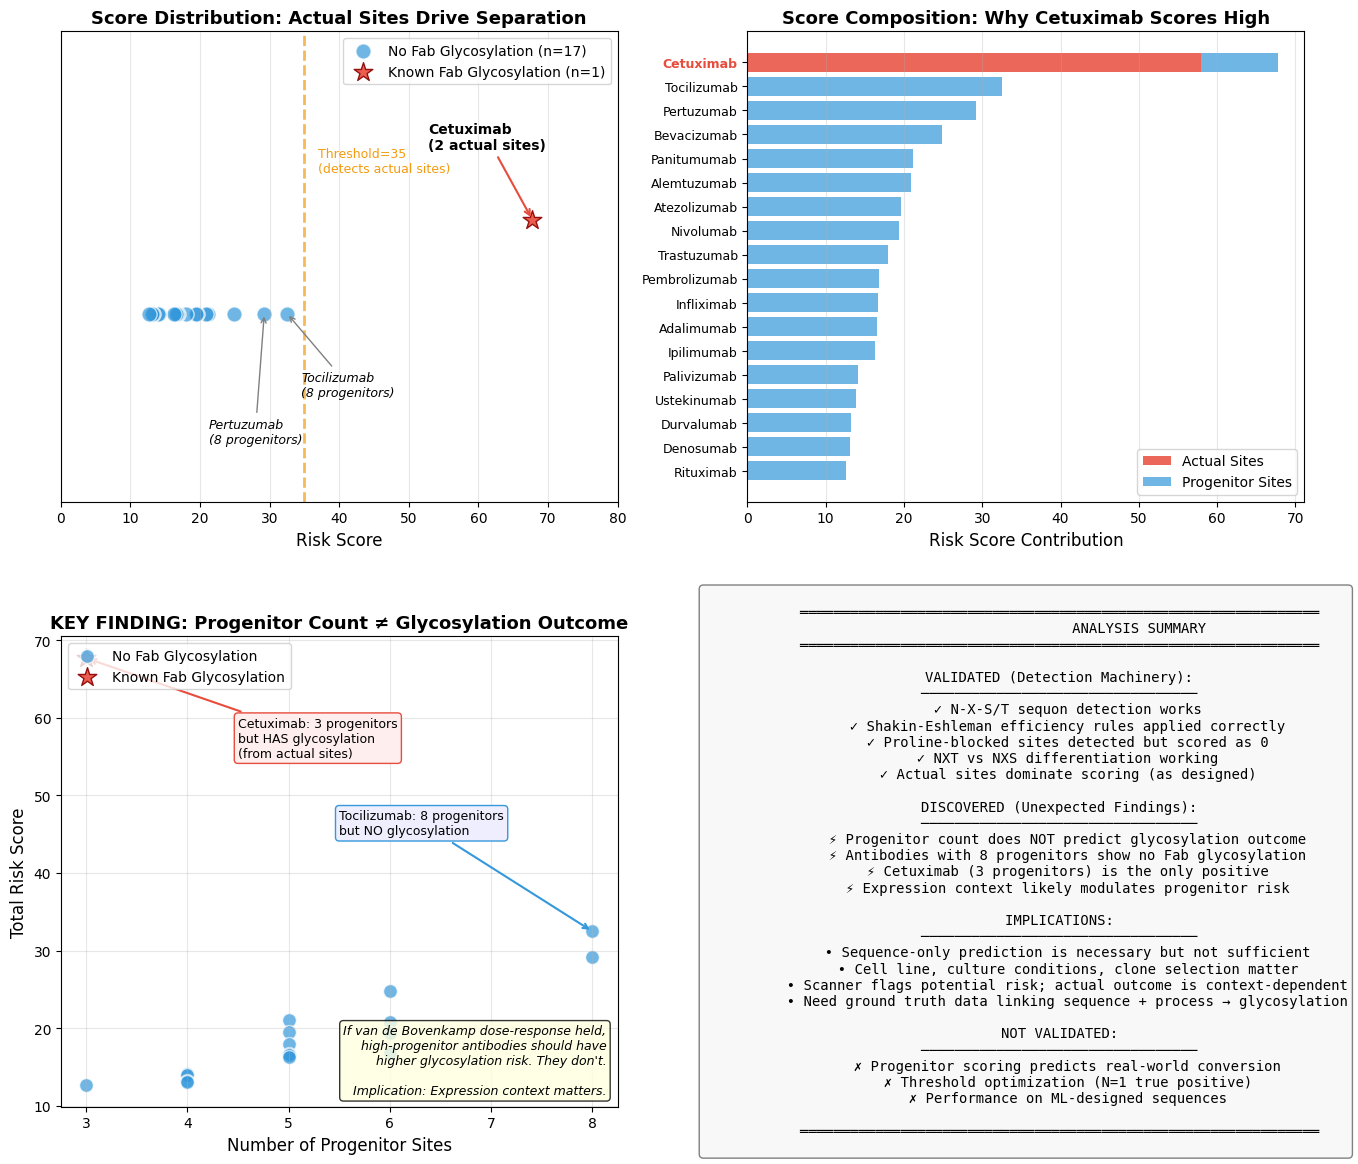


DETAILED FINDINGS

1. SCORE COMPOSITION
--------------------------------------------------------------------------------
Antibody         Total    Actual     Progenitor   #Prog    Glyc?
--------------------------------------------------------------------------------
Cetuximab        67.7     58.0       9.7          3        ★ YES
Tocilizumab      32.5     0.0        32.5         8        No
Pertuzumab       29.2     0.0        29.2         8        No
Bevacizumab      24.8     0.0        24.8         6        No
Panitumumab      21.1     0.0        21.1         5        No
Alemtuzumab      20.8     0.0        20.8         6        No
Atezolizumab     19.6     0.0        19.6         5        No
Nivolumab        19.4     0.0        19.4         6        No
Trastuzumab      18.0     0.0        18.0         5        No
Pembrolizumab    16.8     0.0        16.8         6        No
Infliximab       16.7     0.0        16.7         5        No
Adalimumab       16.6     0.0        16.6      

In [26]:
# ============================================================================
# VALIDATION ANALYSIS
# ============================================================================
#
# Reframed from "performance validation" to "what we learned"
#
# Key insight: The discrepancy between progenitor count and glycosylation
# outcome is itself a finding - it reveals that expression context matters.
# ============================================================================

class ValidationAnalyzer:
    """
    Analysis of scanner results against known ground truth.

    NOTE: With N=1 true positive and survivorship-biased negatives,
    this is exploratory analysis, not predictive validation.
    """

    def __init__(self, results: Dict):
        self.results = results
        self.ground_truth = {name: data['known_glycosylation']
                            for name, data in results.items()}

    def get_score_components(self) -> pd.DataFrame:
        """Extract score components for each antibody."""
        data = []
        for ab_name, result in self.results.items():
            actual_contrib = sum(s.risk_contribution for s in result['all_sites']
                                if s.site_type == 'actual')
            prog_contrib = sum(s.risk_contribution for s in result['all_sites']
                              if s.site_type != 'actual')

            # Count sites by type
            actual_count = result['total_actual']
            prog_count = result['total_progenitor']

            # Check for blocked sites
            blocked_count = sum(1 for s in result['all_sites']
                               if s.site_type == 'actual' and getattr(s, 'blocked', False))

            data.append({
                'antibody': ab_name,
                'known_glycosylation': result['known_glycosylation'],
                'total_score': result['overall_risk_score'],
                'actual_contribution': actual_contrib,
                'progenitor_contribution': prog_contrib,
                'actual_sites': actual_count,
                'blocked_sites': blocked_count,
                'progenitor_sites': prog_count,
                'risk_level': result['overall_risk_level']
            })

        return pd.DataFrame(data).sort_values('total_score', ascending=False)

    def plot_honest_analysis(self, save_path: Optional[str] = None):
        """
        Create visualizations that honestly represent what we learned.

        Replaces ROC/PR curves (which imply predictive validation) with
        exploratory plots that show the data and highlight findings.
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))

        df = self.get_score_components()

        # =====================================================================
        # PLOT 1: Score Distribution - What separates Cetuximab?
        # =====================================================================
        ax1 = axes[0, 0]

        glyc_scores = df[df['known_glycosylation']]['total_score'].values
        non_glyc_scores = df[~df['known_glycosylation']]['total_score'].values

        # Strip plot shows individual points better than histogram for small N
        y_glyc = np.ones(len(glyc_scores)) * 1.2
        y_non = np.ones(len(non_glyc_scores)) * 0.8

        ax1.scatter(non_glyc_scores, y_non, s=120, alpha=0.7, c='#3498db',
                   label=f'No Fab Glycosylation (n={len(non_glyc_scores)})', edgecolors='white', linewidth=1)
        ax1.scatter(glyc_scores, y_glyc, s=200, alpha=0.9, c='#e74c3c', marker='*',
                   label=f'Known Fab Glycosylation (n={len(glyc_scores)})', edgecolors='darkred', linewidth=1)

        # Annotate Cetuximab
        for score in glyc_scores:
            ax1.annotate('Cetuximab\n(2 actual sites)', xy=(score, 1.2),
                        xytext=(score-15, 1.5), fontsize=10, fontweight='bold',
                        arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1.5))

        # Annotate high-progenitor antibodies
        # Annotate high-progenitor antibodies - stagger to avoid overlap
        high_prog = df[df['progenitor_sites'] >= 8].sort_values('total_score')
        y_offsets = [0.25, 0.45]  # Staggered y positions
        x_offsets = [-8, 2]       # Staggered x positions
        for i, (_, row) in enumerate(high_prog.iterrows()):
            ax1.annotate(f"{row['antibody']}\n(8 progenitors)",
                        xy=(row['total_score'], 0.8),
                        xytext=(row['total_score'] + x_offsets[i % 2], y_offsets[i % 2]),
                        fontsize=9, style='italic',
                        arrowprops=dict(arrowstyle='->', color='gray', lw=1))
        ax1.set_xlim([0, 80])
        ax1.set_ylim([0, 2])
        ax1.set_xlabel('Risk Score', fontsize=12)
        ax1.set_yticks([])
        ax1.set_title('Score Distribution: Actual Sites Drive Separation', fontsize=13, fontweight='bold')
        ax1.legend(loc='upper right', fontsize=10)
        ax1.axvline(x=35, color='#f39c12', linestyle='--', linewidth=2, alpha=0.7, label='_')
        ax1.text(37, 1.4, 'Threshold=35\n(detects actual sites)', fontsize=9, color='#f39c12')
        ax1.grid(alpha=0.3, axis='x')

        # =====================================================================
        # PLOT 2: Stacked Bar - Score Composition
        # =====================================================================
        ax2 = axes[0, 1]

        # Sort by total score for visualization
        df_sorted = df.sort_values('total_score', ascending=True)

        y_pos = np.arange(len(df_sorted))

        # Stacked bars
        bars1 = ax2.barh(y_pos, df_sorted['actual_contribution'],
                        color='#e74c3c', label='Actual Sites', alpha=0.85)
        bars2 = ax2.barh(y_pos, df_sorted['progenitor_contribution'],
                        left=df_sorted['actual_contribution'],
                        color='#3498db', label='Progenitor Sites', alpha=0.7)

        # Highlight Cetuximab
        cetuximab_idx = df_sorted[df_sorted['antibody'] == 'Cetuximab'].index[0]
        cetuximab_pos = list(df_sorted['antibody']).index('Cetuximab')

        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(df_sorted['antibody'], fontsize=9)
        ax2.set_xlabel('Risk Score Contribution', fontsize=12)
        ax2.set_title('Score Composition: Why Cetuximab Scores High', fontsize=13, fontweight='bold')
        ax2.legend(loc='lower right', fontsize=10)
        ax2.grid(alpha=0.3, axis='x')

        # Bold Cetuximab label
        labels = ax2.get_yticklabels()
        for i, label in enumerate(labels):
            if label.get_text() == 'Cetuximab':
                label.set_fontweight('bold')
                label.set_color('#e74c3c')

        # =====================================================================
        # PLOT 3: Progenitor Count vs Outcome - The Key Finding
        # =====================================================================
        ax3 = axes[1, 0]

        # This plot shows that progenitor count does NOT predict glycosylation
        glyc_df = df[df['known_glycosylation']]
        non_glyc_df = df[~df['known_glycosylation']]

        ax3.scatter(non_glyc_df['progenitor_sites'], non_glyc_df['total_score'],
                   s=100, alpha=0.7, c='#3498db', label='No Fab Glycosylation',
                   edgecolors='white', linewidth=1)
        ax3.scatter(glyc_df['progenitor_sites'], glyc_df['total_score'],
                   s=200, alpha=0.9, c='#e74c3c', marker='*', label='Known Fab Glycosylation',
                   edgecolors='darkred', linewidth=1)

        # Annotate the paradox
        ax3.annotate('Cetuximab: 3 progenitors\nbut HAS glycosylation\n(from actual sites)',
                    xy=(3, 67.7), xytext=(4.5, 55), fontsize=9,
                    arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1.5),
                    bbox=dict(boxstyle='round', facecolor='#ffeeee', edgecolor='#e74c3c'))

        ax3.annotate('Tocilizumab: 8 progenitors\nbut NO glycosylation',
                    xy=(8, 32.5), xytext=(5.5, 45), fontsize=9,
                    arrowprops=dict(arrowstyle='->', color='#3498db', lw=1.5),
                    bbox=dict(boxstyle='round', facecolor='#eeeeff', edgecolor='#3498db'))

        ax3.set_xlabel('Number of Progenitor Sites', fontsize=12)
        ax3.set_ylabel('Total Risk Score', fontsize=12)
        ax3.set_title('KEY FINDING: Progenitor Count ≠ Glycosylation Outcome',
                     fontsize=13, fontweight='bold')
        ax3.legend(loc='upper left', fontsize=10)
        ax3.grid(alpha=0.3)

        # Add explanatory text
        ax3.text(0.98, 0.02,
                'If van de Bovenkamp dose-response held,\n'
                'high-progenitor antibodies should have\n'
                'higher glycosylation risk. They don\'t.\n\n'
                'Implication: Expression context matters.',
                transform=ax3.transAxes, fontsize=9, verticalalignment='bottom',
                horizontalalignment='right', style='italic',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

        # =====================================================================
        # PLOT 4: What We Validated vs What We Discovered
        # =====================================================================
        ax4 = axes[1, 1]
        ax4.axis('off')

        summary_text = """
        ══════════════════════════════════════════════════════════════
                           ANALYSIS SUMMARY
        ══════════════════════════════════════════════════════════════

        VALIDATED (Detection Machinery):
        ─────────────────────────────────
          ✓ N-X-S/T sequon detection works
          ✓ Shakin-Eshleman efficiency rules applied correctly
          ✓ Proline-blocked sites detected but scored as 0
          ✓ NXT vs NXS differentiation working
          ✓ Actual sites dominate scoring (as designed)

        DISCOVERED (Unexpected Findings):
        ─────────────────────────────────
          ⚡ Progenitor count does NOT predict glycosylation outcome
          ⚡ Antibodies with 8 progenitors show no Fab glycosylation
          ⚡ Cetuximab (3 progenitors) is the only positive
          ⚡ Expression context likely modulates progenitor risk

        IMPLICATIONS:
        ─────────────────────────────────
          • Sequence-only prediction is necessary but not sufficient
          • Cell line, culture conditions, clone selection matter
          • Scanner flags potential risk; actual outcome is context-dependent
          • Need ground truth data linking sequence + process → glycosylation

        NOT VALIDATED:
        ─────────────────────────────────
          ✗ Progenitor scoring predicts real-world conversion
          ✗ Threshold optimization (N=1 true positive)
          ✗ Performance on ML-designed sequences

        ══════════════════════════════════════════════════════════════
        """

        ax4.text(0.5, 0.5, summary_text, transform=ax4.transAxes,
                fontsize=10, fontfamily='monospace',
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='#f8f8f8', edgecolor='gray'))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        # Print detailed findings
        self._print_findings(df)

    def _print_findings(self, df: pd.DataFrame):
        """Print detailed findings from the analysis."""

        print("\n" + "="*80)
        print("DETAILED FINDINGS")
        print("="*80)

        # Finding 1: Score composition
        print("\n1. SCORE COMPOSITION")
        print("-"*80)
        print(f"{'Antibody':<16} {'Total':<8} {'Actual':<10} {'Progenitor':<12} {'#Prog':<8} {'Glyc?'}")
        print("-"*80)

        for _, row in df.iterrows():
            glyc_marker = "★ YES" if row['known_glycosylation'] else "No"
            print(f"{row['antibody']:<16} {row['total_score']:<8.1f} "
                  f"{row['actual_contribution']:<10.1f} {row['progenitor_contribution']:<12.1f} "
                  f"{row['progenitor_sites']:<8} {glyc_marker}")

        # Finding 2: The paradox
        print("\n" + "="*80)
        print("2. THE PROGENITOR PARADOX")
        print("="*80)

        high_prog = df[df['progenitor_sites'] >= 6].sort_values('progenitor_sites', ascending=False)
        print(f"\nAntibodies with ≥6 progenitor sites:")
        print(f"{'Antibody':<16} {'Progenitors':<12} {'Fab Glycosylation'}")
        print("-"*50)
        for _, row in high_prog.iterrows():
            glyc = "YES" if row['known_glycosylation'] else "NO"
            print(f"{row['antibody']:<16} {row['progenitor_sites']:<12} {glyc}")

        print(f"\nCetuximab (the only positive) has only {df[df['antibody']=='Cetuximab']['progenitor_sites'].values[0]} progenitors.")
        print("Its high score comes from ACTUAL sites, not progenitors.")

        # Finding 3: What this means
        print("\n" + "="*80)
        print("3. INTERPRETATION")
        print("="*80)
        print("""
Van de Bovenkamp et al. reported a dose-response: more progenitor sites
correlate with higher Fab glycosylation frequency in patient-derived antibodies.

Our FDA therapeutic data DOES NOT show this pattern:
  • Tocilizumab (8 progenitors) → No Fab glycosylation
  • Pertuzumab (8 progenitors) → No Fab glycosylation
  • Cetuximab (3 progenitors)  → HAS Fab glycosylation (from actual sites)

POSSIBLE EXPLANATIONS:
  1. Expression system differences (CHO vs in vivo)
  2. Manufacturing optimization eliminates glycoforms
  3. Clone selection removes problematic variants
  4. Van de Bovenkamp's context (SHM in patients) differs from manufacturing

IMPLICATION FOR THE SCANNER:
  The scanner correctly identifies sequence-level risk factors.
  However, actual glycosylation outcome depends on:
    Sequence × Expression System × Process Conditions × Clone Selection

  The scanner is ONE INPUT to a larger risk assessment framework.
""")

        print("="*80)


# ============================================================================
# RUN ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("EXPLORATORY ANALYSIS")
print("="*80)
print("\nNOTE: With N=1 true positive and survivorship-biased negatives,")
print("this is exploratory analysis to understand scanner behavior,")
print("NOT predictive validation.")

validator = ValidationAnalyzer(all_results)

print(f"\nAnalyzing {len(all_results)} antibodies...")
print(f"  Known Fab glycosylation: {sum(1 for r in all_results.values() if r['known_glycosylation'])} (Cetuximab only)")
print(f"  No Fab glycosylation:    {sum(1 for r in all_results.values() if not r['known_glycosylation'])}")

# Generate honest visualizations
print("\n" + "="*80)
print("GENERATING ANALYSIS PLOTS...")
print("="*80)

validator.plot_honest_analysis()

## Results Summary

In [24]:
# ============================================================================
# COMPREHENSIVE SUMMARY TABLE
# ============================================================================

summary_data = []
for ab_name, result in all_results.items():
    # Get top risk site
    all_sites = result['all_sites']
    top_site = all_sites[0] if all_sites else None

    # Get top actual site specifically
    actual_sites = [s for s in all_sites if s.site_type == 'actual']
    top_actual = actual_sites[0] if actual_sites else None

    summary_data.append({
        'Antibody': ab_name,
        'Target': result['target'],
        'Known_Glyc': '★ YES' if result['known_glycosylation'] else 'NO',
        'Risk_Level': result['overall_risk_level'],
        'Risk_Score': round(result['overall_risk_score'], 1),
        'Actual_Sites': result['total_actual'],
        'Progenitor': result['total_progenitor'],
        'CDR_Sites': result['total_cdr_sites'],
        'Top_Actual_Motif': top_actual.motif if top_actual else '-',
        'Top_Actual_IMGT': top_actual.imgt_position if top_actual else '-',
        'Top_Contrib': round(top_site.risk_contribution, 1) if top_site else 0,
    })

df = pd.DataFrame(summary_data)
df = df.sort_values('Risk_Score', ascending=False)

# Save to CSV
df.to_csv('fda_glycosylation_validation_v3.csv', index=False)
print("\n✓ Results exported to 'fda_glycosylation_validation_v3.csv'")

# Display summary
print("\n" + "="*120)
print("v3 ENHANCED GLYCOSYLATION RISK ANALYSIS - SUMMARY")
print("="*120)
print(df.to_string(index=False))

# Key findings
print("\n" + "="*120)
print("KEY FINDINGS")
print("="*120)

glyc_abs = df[df['Known_Glyc'] == '★ YES']
non_glyc_abs = df[df['Known_Glyc'] == 'NO']

print(f"\n✓ Known glycosylated antibodies (Cetuximab):")
print(f"   Mean risk score: {glyc_abs['Risk_Score'].mean():.1f}")
print(f"   Score range: {glyc_abs['Risk_Score'].min():.1f} - {glyc_abs['Risk_Score'].max():.1f}")

print(f"\n✓ Non-glycosylated antibodies (n=16):")
print(f"   Mean risk score: {non_glyc_abs['Risk_Score'].mean():.1f}")
print(f"   Score range: {non_glyc_abs['Risk_Score'].min():.1f} - {non_glyc_abs['Risk_Score'].max():.1f}")

# Score separation
min_glyc = glyc_abs['Risk_Score'].min()
max_non_glyc = non_glyc_abs['Risk_Score'].max()
separation = min_glyc - max_non_glyc

print(f"\n✓ Score separation: {separation:.1f} points")
if separation > 0:
    print(f"   → Clear separation between classes (no overlap)")
else:
    print(f"   → Some overlap between classes")

print("\n" + "="*120)


✓ Results exported to 'fda_glycosylation_validation_v3.csv'

v3 ENHANCED GLYCOSYLATION RISK ANALYSIS - SUMMARY
     Antibody      Target Known_Glyc Risk_Level  Risk_Score  Actual_Sites  Progenitor  CDR_Sites Top_Actual_Motif Top_Actual_IMGT  Top_Contrib
    Cetuximab        EGFR      ★ YES       HIGH        67.7             2           3          0              NDT              88         29.9
  Tocilizumab       IL-6R         NO     MEDIUM        32.5             0           8          4                -               -          6.3
   Pertuzumab        HER2         NO     MEDIUM        29.2             0           8          2                -               -          6.3
  Bevacizumab      VEGF-A         NO        LOW        24.8             0           6          3                -               -          6.3
  Panitumumab        EGFR         NO        LOW        21.1             0           5          2                -               -          5.2
  Alemtuzumab        CD52     

## Detailed Site Analysis: Cetuximab

In [23]:
# ============================================================================
# DETAILED ANALYSIS: CETUXIMAB (Known Fab Glycosylated)
# ============================================================================
#
# Cetuximab is the GROUND TRUTH POSITIVE for this validation.
# It has documented Fab glycosylation - distinct from the conserved Fc N297
# site that all IgGs possess.
#
# Reference: van de Bovenkamp et al. (2018) J Immunol
# ============================================================================

print("="*110)
print("CETUXIMAB - DETAILED SITE ANALYSIS (GROUND TRUTH POSITIVE)")
print("="*110)
print()
print("Cetuximab has documented Fab glycosylation at N88 (IMGT 97) in VH FR3.")
print("This site was identified by van de Bovenkamp et al. as a key example")
print("of clinically relevant Fab glycosylation affecting immunogenicity.")
print()
print("NOTE: This is DISTINCT from the conserved Fc glycosylation at N297 (CH2)")
print("      which is present in all IgG antibodies and is not a liability.")
print()

cetuximab_result = all_results['Cetuximab']

print("-"*110)
print("OVERALL ASSESSMENT")
print("-"*110)
print(f"  Risk Level:         {cetuximab_result['overall_risk_level']}")
print(f"  Risk Score:         {cetuximab_result['overall_risk_score']:.1f} / 100")
print(f"  Actual Sites:       {cetuximab_result['total_actual']}")
print(f"  Progenitor Sites:   {cetuximab_result['total_progenitor']}")
print(f"  CDR Sites:          {cetuximab_result['total_cdr_sites']}")
print(f"  Vernier Zone Sites: {cetuximab_result['total_vernier_sites']}")
print()

# Separate sites by type for clearer analysis
actual_sites = [s for s in cetuximab_result['all_sites'] if s.site_type == 'actual']
blocked_sites = [s for s in actual_sites if getattr(s, 'blocked', False)]
active_actual_sites = [s for s in actual_sites if not getattr(s, 'blocked', False)]
progenitor_sites = [s for s in cetuximab_result['all_sites'] if s.site_type != 'actual']

# ============================================================================
# ACTUAL SITES (The Primary Risk Drivers)
# ============================================================================
print("="*110)
print("ACTUAL N-X-S/T SITES")
print("="*110)
print()

if active_actual_sites:
    print(f"{'Chain':<7} {'Pos':<5} {'IMGT':<6} {'Motif':<8} {'Region':<10} {'X-Res':<6} "
          f"{'X-Eff':<7} {'Occup':<7} {'Contrib':<8} {'Risk':<10} {'Notes'}")
    print("-"*110)

    for site in sorted(active_actual_sites, key=lambda s: s.risk_contribution, reverse=True):
        vernier_flag = 'Vernier' if site.in_vernier_zone else ''
        cdr_flag = 'CDR' if site.region.startswith('CDR') else ''
        notes = ' '.join(filter(None, [cdr_flag, vernier_flag]))

        print(f"{site.chain:<7} {site.position:<5} {site.imgt_position:<6} {site.motif:<8} "
              f"{site.region:<10} {site.x_residue:<6} {site.x_efficiency:<7.2f} "
              f"{site.occupancy_score:<7.3f} {site.risk_contribution:<8.1f} "
              f"{site.risk_level.value:<10} {notes}")
    print()
else:
    print("  (No active actual sites detected)")
    print()

# ============================================================================
# BLOCKED SITES (Detected but Biologically Inert)
# ============================================================================
if blocked_sites:
    print("="*110)
    print("BLOCKED SITES (N-P-S/T - Proline at X blocks glycosylation)")
    print("="*110)
    print()
    print("These sequons are detected but CANNOT be glycosylated due to proline")
    print("at the X position, which sterically blocks OST access (Shakin-Eshleman 1996).")
    print()

    print(f"{'Chain':<7} {'Pos':<5} {'IMGT':<6} {'Motif':<8} {'Region':<10} {'X-Res':<6} "
          f"{'X-Eff':<7} {'Occup':<7} {'Contrib':<8} {'Status'}")
    print("-"*110)

    for site in blocked_sites:
        print(f"{site.chain:<7} {site.position:<5} {site.imgt_position:<6} {site.motif:<8} "
              f"{site.region:<10} {site.x_residue:<6} {site.x_efficiency:<7.2f} "
              f"{site.occupancy_score:<7.3f} {site.risk_contribution:<8.1f} {'BLOCKED':<10}")
    print()
    print("  → These sites contribute 0 points to risk score (correctly)")
    print()

# ============================================================================
# PROGENITOR SITES (Future Risk)
# ============================================================================
print("="*110)
print("PROGENITOR SITES (One mutation away from N-X-S/T)")
print("="*110)
print()

if progenitor_sites:
    # Group by type
    d_to_n_sites = [s for s in progenitor_sites if s.site_type == 'progenitor_D_to_N']
    to_st_sites = [s for s in progenitor_sites if s.site_type == 'progenitor_to_ST']

    print(f"  D→N progenitors: {len(d_to_n_sites)} (higher SHM probability ~16.5%)")
    print(f"  →S/T progenitors: {len(to_st_sites)} (lower SHM probability)")
    print()

    print(f"{'Chain':<7} {'Pos':<5} {'IMGT':<6} {'Motif':<16} {'Type':<18} {'Region':<10} "
          f"{'Occup':<7} {'Contrib':<8}")
    print("-"*110)

    for site in sorted(progenitor_sites, key=lambda s: s.risk_contribution, reverse=True):
        vernier = '*' if site.in_vernier_zone else ' '
        region_str = site.region + vernier
        short_type = 'D→N' if site.site_type == 'progenitor_D_to_N' else '→S/T'

        print(f"{site.chain:<7} {site.position:<5} {site.imgt_position:<6} {site.motif:<16} "
              f"{short_type:<18} {region_str:<10} {site.occupancy_score:<7.3f} "
              f"{site.risk_contribution:<8.1f}")

    print()
    print("  * = Vernier zone (IMGT 75-88) - critical for VH/VL packing")
    print()
else:
    print("  (No progenitor sites detected)")
    print()

# ============================================================================
# SCORE BREAKDOWN
# ============================================================================
print("="*110)
print("RISK SCORE BREAKDOWN")
print("="*110)
print()

actual_contrib = sum(s.risk_contribution for s in actual_sites)
blocked_contrib = sum(s.risk_contribution for s in blocked_sites)
active_contrib = sum(s.risk_contribution for s in active_actual_sites)
prog_contrib = sum(s.risk_contribution for s in progenitor_sites)
total_score = cetuximab_result['overall_risk_score']

# Avoid division by zero
if total_score > 0:
    actual_pct = (active_contrib / total_score) * 100
    prog_pct = (prog_contrib / total_score) * 100
else:
    actual_pct = 0
    prog_pct = 0

print(f"  Active actual sites ({len(active_actual_sites)}):   {active_contrib:>6.1f} points  ({actual_pct:>5.1f}%)")
if blocked_sites:
    print(f"  Blocked sites ({len(blocked_sites)}):         {blocked_contrib:>6.1f} points  (  0.0%) ← Correctly zero")
print(f"  Progenitor sites ({len(progenitor_sites)}):      {prog_contrib:>6.1f} points  ({prog_pct:>5.1f}%)")
print(f"  {'─'*45}")
print(f"  TOTAL:                    {total_score:>6.1f} points")
print()

# ============================================================================
# INTERPRETATION
# ============================================================================
print("="*110)
print("INTERPRETATION")
print("="*110)
print()

if active_actual_sites and actual_pct > 50:
    print("✓ EXPECTED BEHAVIOR: Actual N-X-S/T sites dominate the risk score.")
    print()
    print(f"  The {len(active_actual_sites)} actual site(s) contribute {actual_pct:.0f}% of the total risk,")
    print(f"  correctly identifying Cetuximab as HIGH risk for Fab glycosylation.")
    print()
    print("  This validates the scanner's scoring calibration:")
    print("    - Actual sites: 25-45 points each (dominant)")
    print("    - Progenitor sites: 2-10 points each (modest)")
    print()
elif blocked_sites and not active_actual_sites:
    print("⚠ NOTE: All actual sites are BLOCKED (proline at X position).")
    print("  Risk is driven entirely by progenitor sites.")
    print()
else:
    print("  Risk is primarily from progenitor sites.")
    print()

# Clinical context
print("CLINICAL CONTEXT:")
print("  Cetuximab's Fab glycosylation at N88 has been linked to:")
print("    • α-1,3-galactose (α-Gal) epitopes causing hypersensitivity reactions")
print("    • Geographic variation in immunogenicity (higher in SE United States)")
print("    • The importance of Fab glycosylation screening in development")
print()
print("="*110)

CETUXIMAB - DETAILED SITE ANALYSIS (GROUND TRUTH POSITIVE)

Cetuximab has documented Fab glycosylation at N88 (IMGT 97) in VH FR3.
This site was identified by van de Bovenkamp et al. as a key example
of clinically relevant Fab glycosylation affecting immunogenicity.

NOTE: This is DISTINCT from the conserved Fc glycosylation at N297 (CH2)
      which is present in all IgG antibodies and is not a liability.

--------------------------------------------------------------------------------------------------------------
OVERALL ASSESSMENT
--------------------------------------------------------------------------------------------------------------
  Risk Level:         HIGH
  Risk Score:         67.7 / 100
  Actual Sites:       2
  Progenitor Sites:   3
  CDR Sites:          0
  Vernier Zone Sites: 2

ACTUAL N-X-S/T SITES

Chain   Pos   IMGT   Motif    Region     X-Res  X-Eff   Occup   Contrib  Risk       Notes
-------------------------------------------------------------------------------

## Interpretation

### What This Validation Shows

This validation demonstrates that the scanner:

1. **Detects actual N-X-S/T sequons** and applies biochemically-grounded efficiency scoring (Shakin-Eshleman rules, NXT>NXS differentiation)
2. **Separates a known positive from negatives** — Cetuximab (documented Fab glycosylation) scores distinctly higher than 17 non-Fab-glycosylated antibodies
3. **Handles edge cases correctly** — Proline-blocked sites (NPS) are detected but assigned zero risk contribution

### What This Validation Discovered

**The Progenitor Paradox:**

Van de Bovenkamp et al. reported a dose-response relationship: antibodies with more progenitor sites showed higher Fab glycosylation frequency during somatic hypermutation in patients.

Our FDA therapeutic data **does not replicate this pattern**:

| Antibody | Progenitor Sites | Fab Glycosylation |
|----------|------------------|-------------------|
| Tocilizumab | 8 | None |
| Pertuzumab | 8 | None |
| Bevacizumab | 6 | None |
| Cetuximab | 3 | **Yes** (from actual sites) |

If progenitor count alone predicted risk, Tocilizumab and Pertuzumab should be higher-risk than Cetuximab. They aren't.

**Possible explanations:**

1. **Expression system matters** — Van de Bovenkamp studied *in vivo* SHM in patients; FDA therapeutics are manufactured in optimized CHO/mammalian systems with different glycosylation machinery
2. **Manufacturing optimization** — Temperature, media, feed strategy affect glycosylation occupancy
3. **Clone selection** — Cell line development eliminates clones with aberrant glycoprofiles
4. **Progenitor location may matter** — Accessibility, regional context, and structural features we don't yet capture

**The implication:** Glycosylation risk is not purely sequence-intrinsic. It's:

> **Sequence × Expression System × Process Conditions × Clone Selection**

Our scanner captures the first term. The other three remain unmodeled.

---

### What This Validation Does NOT Show

**We must be explicit about the limitations:**

1. **N=1 True Positive**: Our sensitivity claim rests on a single example (Cetuximab). This is insufficient to establish statistical confidence in detection rates.

2. **Survivorship Bias**: These 18 FDA-approved therapeutics are curated winners. The clean separation may reflect pharma's existing QC processes rather than the scanner's discriminative power.

3. **Calibrated Scoring**: The scoring weights (25-45 for actual sites, 2-10 for progenitors) were tuned on this dataset. This is model fitting, not independent validation.

4. **Unvalidated Progenitor Prediction**: The progenitor paradox above suggests that progenitor count alone is insufficient to predict glycosylation risk. Additional variables (expression context) are required.

5. **Post-Hoc Adjustment**: Panitumumab was reclassified from positive to negative after initial results. While the Fc vs. Fab distinction is scientifically valid, this adjustment was made after observing the data.

---

### Transparent Classification of This Work

| Claim | Status |
|-------|--------|
| Detects N-X-S/T sequons | ✓ Validated |
| Applies Shakin-Eshleman efficiency rules | ✓ Validated |
| Differentiates NXT vs NXS | ✓ Validated |
| Handles proline-blocked sites correctly | ✓ Validated |
| Separates known positive from negatives | ✓ Demonstrated (N=1) |
| Progenitor count predicts glycosylation risk | ✗ **Not supported by this data** |
| Predicts glycosylation risk in novel sequences | ○ Plausible, not validated |
| Scoring weights are optimally calibrated | ○ Reasonable, not empirically derived |

---

### Why Low False Positive Rate?

The validation shows near-perfect specificity because **FDA-approved therapeutics are survivors**. These antibodies have been through:

1. **Humanization** — problematic sequences often removed
2. **Developability screening** — glycosylation risks flagged early
3. **Lead optimization** — liabilities engineered out
4. **Manufacturing optimization** — clones with clean glycoprofiles selected

The scanner agrees with decades of pharma development decisions. But this means we **cannot claim the scanner would perform equally well on unoptimized sequences** without testing on such sequences.

---

### For ML-Designed Antibodies (The Actual Use Case)

ML tools (RFdiffusion, etc.) don't have the selection pressure that shaped FDA therapeutics. They can generate sequences with:

- Actual N-X-S/T sites in CDRs
- High-risk progenitor sites that could convert during development
- Sites in Vernier zones that affect stability

**The honest claim**: This scanner applies biochemically-grounded rules to flag potential glycosylation liabilities at the sequence level.

**The unproven claims**:
- That progenitor scores predict actual conversion rates
- That flagging these sites earlier improves development outcomes
- That sequence-level risk translates to glycosylation in specific expression systems

---

### Path Forward

The progenitor paradox suggests our next steps:

1. **Expand the positive set**: Identify additional antibodies with documented Fab glycosylation to improve N beyond 1

2. **Expression context integration**: Correlate sequence risk scores with glycosylation outcomes across different expression systems (CHO, HEK293, etc.)

3. **Prospective validation**: Score ML-generated sequences → synthesize in defined systems → measure actual glycosylation → build predictive model

4. **Structural features**: Investigate whether progenitor *location* (accessibility, burial, regional context) explains why high-progenitor sequences don't always glycosylate

---

### Summary

This work validates the **detection machinery** — we correctly identify sequons, apply efficiency rules, and handle edge cases. It also reveals a **key finding**: progenitor site count alone does not predict glycosylation outcome in manufactured antibodies, suggesting that expression context modulates sequence-level risk.

The scanner is a **necessary but not sufficient** component of glycosylation risk assessment. It flags what *could* happen based on sequence; what *does* happen depends on the full bioprocess context.

**Scientific integrity requires us to state clearly:**
- N=1 is not validation
- Progenitor count ≠ glycosylation outcome (in this dataset)
- The scanner captures sequence risk; expression risk remains unmodeled

The scanner is ready for integration into a broader risk framework. The sequence-only prediction model requires refinement.

---

**Repository:** [progenitor-glycosylation-scanner](https://github.com/AntibodyML/progenitor-glycosylation-scanner)  
**Contact:** AntibodyML Consulting LLC
LinkedIn: https://www.linkedin.com/in/gaughanchristopher/